# Controllable Synthesis of Instrument Sounds
## Given pitches and instrument to play with (loading widgets can take a while ...)

In [1]:
#nbi:hide_in
import torch
import data_loader.data_loaders as module_data
from data_loader.data_loaders import NormDataLoader
import model.model as module_arch
from utils import get_instance
import math
import librosa
from IPython.display import display, Audio
from tqdm import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

model_path = '/data/yinjyun/projects/gmvae-timbre/gmvae_v2-timbre/saved/Sol_GMVAE_v2/melspec_256-first_chunk-include_onset-fix_piano-normalize-ss_1.0-latent_16-pow_0-lvl_0-pc_1-pd_1-val_lower_bound/model_best.pth'
sr = 22050
n_fft = 2048
n_mel = 256
hop_length = 256
fmin = 27
fmax = 11000

def griffinlim(spectrogram, n_iter = 100, window = 'hann', n_fft = 2048, hop_length = -1, verbose = False):
    if hop_length == -1:
        hop_length = n_fft // 4

    angles = np.exp(2j * np.pi * np.random.rand(*spectrogram.shape))

    t = tqdm(range(n_iter), ncols=100, mininterval=2.0, disable=not verbose)
    for i in t:
        full = np.abs(spectrogram).astype(np.complex) * angles
        inverse = librosa.istft(full, hop_length = hop_length, window = window)
        rebuilt = librosa.stft(inverse, n_fft = n_fft, hop_length = hop_length, window = window)
        angles = np.exp(1j * np.angle(rebuilt))

        if verbose:
            diff = np.abs(spectrogram) - np.abs(rebuilt)
            t.set_postfix(loss=np.linalg.norm(diff, 'fro'))

    full = np.abs(spectrogram).astype(np.complex) * angles
    inverse = librosa.istft(full, hop_length = hop_length, window = window)

    return inverse


def denormalize(S, d_min, d_max):
    S = ((S + 1) / (2)) * (d_max - d_min) + d_min
    S = np.exp(S)
    return S

dl_norm = NormDataLoader(data_dir="/data/yinjyun/datasets/sol/acidsInstruments-ordinario/data/melspec_256-first_chunk-include_onset-fix_piano/",
                         batch_size=512, validation_split=0.1, shuffle=True, num_workers=0)

d_max = -math.inf
d_min = math.inf
for i, (data, target, idx) in enumerate(dl_norm):
    if data.max().item() > d_max:
        d_max = data.max().item()    
    if data.min().item() < d_min:
        d_min = data.min().item()
        
mel_filter = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mel, fmin=fmin, fmax=fmax)

resume = torch.load(model_path)
config = resume['config']
n_class = config['arch']['args']['n_class']
latent_dim = config['arch']['args']['latent_dim']
batch_size = config['data_loader']['args']['batch_size']
model = get_instance(module_arch, 'arch', config)
# model.summary()
model.load_state_dict(resume['state_dict'])
model.eval()
model.is_featExtract = False
data_loader = get_instance(module_data, 'data_loader', config)
valid_data_loader = data_loader.split_validation()

pitch_map = data_loader.dataset.pitch_map
pitchclass_map = data_loader.dataset.pitchclass_map
octave_map = {str(k): v for k, v in enumerate(range(8))}
inv_pitch_map = {v: k for k, v in pitch_map.items()}
inv_pitchclass_map = {v: k for k, v in pitchclass_map.items()}
desired_ins_key = ['Ehn', 'Fhn', 'Trtb', 'Trop', 'Pno', 'Vn', 'Vc', 'Sax', 'Bn', 'Clr', 'Fl', 'Ob']
ins_map = {i: n for n, i in enumerate(desired_ins_key)}
inv_ins_map = {v: k for k, v in ins_map.items()}

def control_syn(octave, pitchclass, instrument):
    plt.close()
    pitch = inv_pitchclass_map[pitchclass] + str(octave)
    print(pitch, inv_ins_map[instrument])
    t_id, p_id = instrument, pitch_map[pitch]
    t_id, p_id = torch.tensor(t_id), torch.tensor(p_id)
    mu_t = model.mu_lookup(t_id).data.unsqueeze(0)
    logvar_t = model.logvar_lookup(t_id).data.unsqueeze(0)
    mu_p = model.pitch_mu_lookup(p_id).unsqueeze(0)
    logvar_p = model.pitch_logvar_lookup(p_id).unsqueeze(0)
    z_t = model._infer_latent(mu_t, logvar_t, weight=1)[2]
    z_p = model._infer_latent(mu_p, logvar_p, weight=1)[2]
    S = model._decode(torch.cat([z_t, z_p], dim=1)).data.numpy().squeeze(0)
    S = denormalize(S, d_min, d_max)
    plt.imshow(librosa.power_to_db(S), aspect='auto', origin='lower')
    S_stft = np.dot(mel_filter.T, S)
    x = griffinlim(S_stft, n_iter=50, n_fft=n_fft, hop_length=hop_length)
    display(Audio(x, rate=sr))
from ipywidgets import interact
interact(control_syn, octave=octave_map, pitchclass=pitchclass_map, instrument=ins_map)

interactive(children=(Dropdown(description='octave', options={'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, …

<function __main__.control_syn(octave, pitchclass, instrument)>

### Examples of all 12 instruments played in C4, E4, G4

Ehn ['C4', 'E4', 'G4']


Fhn ['C4', 'E4', 'G4']


Trtb ['C4', 'E4', 'G4']


Trop ['C4', 'E4', 'G4']


Pno ['C4', 'E4', 'G4']


Vn ['C4', 'E4', 'G4']


Vc ['C4', 'E4', 'G4']


Sax ['C4', 'E4', 'G4']


Bn ['C4', 'E4', 'G4']


Clr ['C4', 'E4', 'G4']


Fl ['C4', 'E4', 'G4']


Ob ['C4', 'E4', 'G4']


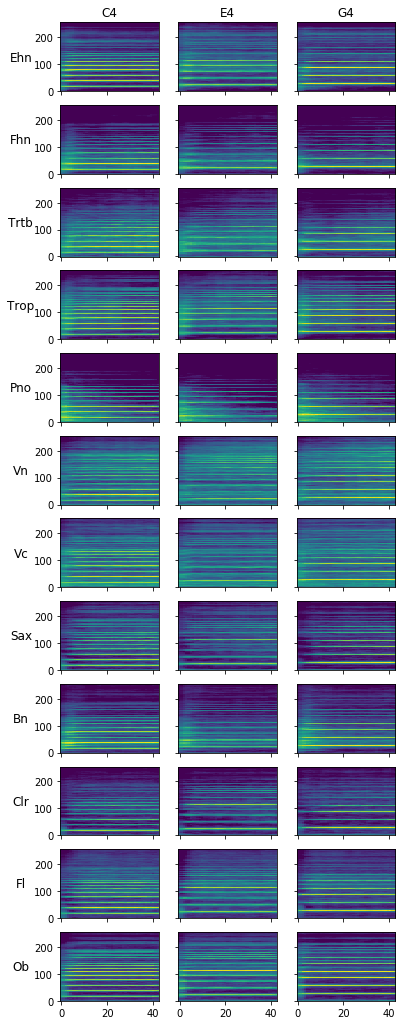

In [2]:
#nbi:hide_in
scale = ['C4', 'E4', 'G4']
# scale = ['C4', 'F4', 'A4', 'C5']
# scale = ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4', 'C5']
# scale = ['C2', 'C3', 'C4','C5']
# scale = ['C4', 'C#4', 'D4','D#4', 'E4', 'F4', 'F#4']

scale_ind = [pitch_map[i] for i in scale]
desired = [ins_map[i] for i in desired_ins_key]
weight = 0  # sampling from the mode - the means of each mixture component
fig, ax = plt.subplots(len(desired), len(scale), figsize=(len(scale) * 2, len(desired) * 1.5), sharex=True, sharey=True)
model.is_featExtract = False
for i, n in enumerate(desired):
    n = torch.tensor(n)
    mu_k = model.mu_lookup(n).data.unsqueeze(0)
    logvar_k = model.logvar_lookup(n).data.unsqueeze(0)
    if i == 0:
        mu_prior = mu_k
        logvar_prior = logvar_k
    else:
        mu_prior = torch.cat([mu_prior, mu_k], dim=0)
        logvar_prior = torch.cat([logvar_prior, logvar_k], dim=0)

    z_t = model._infer_latent(mu_k, logvar_k, weight=weight)[2]  # sample from prior

    for m, (pitch_name, pitch_ind) in enumerate(zip(scale, torch.tensor(scale_ind))):
        mu_m = model.pitch_mu_lookup(pitch_ind).unsqueeze(0)
        logvar_m = model.pitch_logvar_lookup(pitch_ind).unsqueeze(0)
        # pitch_emb = model.pitch_mu_lookup(pitch_ind).unsqueeze(0)
        z_p = model._infer_latent(mu_m, logvar_m, weight=weight)[2]
        S = model._decode(torch.cat([z_t, z_p], dim=1)).data.numpy().squeeze(0)
        S = denormalize(S, d_min, d_max)
        ax[i][m].imshow(librosa.power_to_db(S), aspect='auto', origin='lower')
        S_stft = np.dot(mel_filter.T, S)
        x = griffinlim(S_stft, n_iter=50, n_fft=n_fft, hop_length=hop_length)

        if i == 0:
            ax[i][m].set_title(pitch_name)
        if m == 0:
            print(inv_ins_map[n.item()], scale)
            ax[i][m].set_ylabel(inv_ins_map[n.item()], rotation=0, size='large')
            ax[i][m].yaxis.set_label_coords(-0.4, 0.4)
        display(Audio(x, rate=sr))